In [251]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
sp.init_printing()
import bayesian_pdes as bpdes
import matplotlib
import gpanim
#matplotlib.rc('text', usetex=True)
#matplotlib.rcParams['text.latex.unicode'] = True

In [252]:
true = np.loadtxt('true_linear_elliptic.txt')
true_x = true[:,:2]
seed = 124
np.random.seed(seed)
r = np.random.normal(0, 0.1, len(true))
print r
true_u = (true[:,2] + r).reshape((len(true), 1))

[ 0.02884791 -0.04629541 -0.13380044  0.23170157 -0.14673759 -0.07485477
 -0.10175214  0.16350668  0.09225456 -0.07198813 -0.09648834  0.02535828
  0.03080074 -0.0071606  -0.11354805 -0.01022454  0.08081862  0.02319924
 -0.14003585  0.07159078 -0.21245676  0.12414134  0.0236312  -0.10888918
  0.07177592  0.00434045 -0.02952642 -0.01971579  0.08078603 -0.10767565
  0.04913325 -0.04511359  0.01965904 -0.21584157  0.05226973  0.01942622]


In [253]:
coefs = [
    (0,0),
    (1,0),
    (0,1),
    (1,1),
    (2,0),
    (0,2)
]

In [254]:
S = 6
x_1, x_2, y_1, y_2 = sp.symbols('x_1 x_2 y_1 y_2')
thetas = list(sp.symbols(' '.join(['theta_{}'.format(i) for i in xrange(S)])))
def get_c(x_1, x_2):
    c = sp.exp(sum([theta*sp.cos(2*sp.pi*(coefs[i][0]*x_1+coefs[i][1]*x_2)) / (i+1)**2 for i,theta in enumerate(thetas)]))
    return c

In [255]:
length_scale = 0.1
k_sqexp = sp.exp(-((x_1-y_1)**2 + (x_2-y_2)**2) / (2*length_scale**2))
A = lambda k: (get_c(x_1, x_2)*k.diff(x_1)).diff(x_1) + (get_c(x_1, x_2)*k.diff(x_2)).diff(x_2)
Abar = lambda k: (get_c(y_1, y_2)*k.diff(y_1)).diff(y_1) + (get_c(y_1, y_2)*k.diff(y_2)).diff(y_2)
Identity = lambda k: k
B_1 = Identity
B_1_bar = Identity
B_2 = lambda k: k.diff(x_1)
B_2_bar = lambda k: k.diff(y_1)

In [256]:
ops = [A, B_1, B_2]
ops_bar = [Abar, B_1_bar, B_2_bar]
op_cache = bpdes.generate_op_cache(ops, ops_bar, k_sqexp, [[x_1, x_2], [y_1, y_2], thetas], mode='compile')
#op_cache = compiled_oc

In [257]:
all_x, all_y = np.mgrid[0:1:21j, 0:1:21j]
all = np.c_[all_x.ravel(), all_y.ravel()]
neumann_flags = ((all[:,0] == 0) | (all[:,0] == 1)) & (all[:,1] != 0) & (all[:,1] != 1)
dirichlet_flags = ((all[:,1] == 0) | (all[:,1] == 1))
interior_flags = ~neumann_flags & ~dirichlet_flags
dirichlet = all[dirichlet_flags, :]
neumann = all[neumann_flags, :]
interior = all[interior_flags, :]

In [258]:
interior_obs = np.zeros((interior.shape[0], 1))

dirichlet_obs = dirichlet[:,0].copy()
dirichlet_obs[dirichlet[:,1] == 1] = 1-dirichlet_obs[dirichlet[:,1] == 1]
dirichlet_obs = dirichlet_obs[:,None]

#dirichlet_obs = 2-dirichlet_obs

neumann_obs = np.zeros((neumann.shape[0], 1))

obs = [
    (interior, interior_obs),
    (dirichlet, dirichlet_obs),
    (neumann, neumann_obs)
]

In [259]:
true_theta = np.ones(S)

posterior = bpdes.collocate(ops, ops_bar, None, None, obs, op_cache, fun_args=[true_theta])

In [260]:
test_x, test_y = np.mgrid[0:1:40j,0:1:40j]
mu, Sigma = posterior(np.c_[test_x.ravel(), test_y.ravel()])
mu_shaped = mu.reshape(test_x.shape)

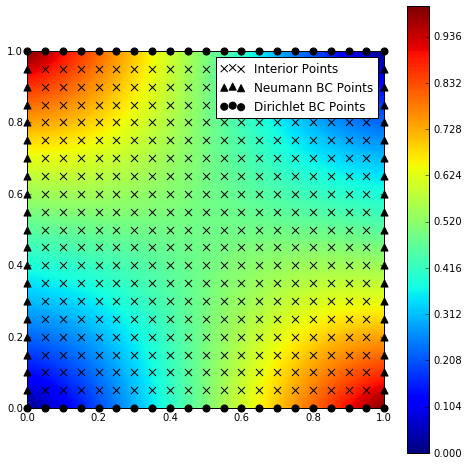

In [261]:
plt.figure(figsize=(8,8))
import matplotlib.tri as tri
#plt.tripcolor(test_x.ravel(), test_y.ravel(), mu.ravel())
colors = plt.contourf(test_x, test_y, mu_shaped,  250)
plt.colorbar(colors)
plt.scatter(interior[:,0], interior[:,1],  marker='x', c='black', s=50, label='Interior Points')
plt.scatter(neumann[:,0], neumann[:,1], marker='^', c='black', clip_on=False, s=50, label='Neumann BC Points')
plt.scatter(dirichlet[:,0], dirichlet[:,1], marker='o', c='black', clip_on=False, s=50, label='Dirichlet BC Points')
plt.legend()
plt.axis('scaled')
plt.xlim(0,1); plt.ylim(0,1);
plt.gcf().patch.set_alpha(0.0)
plt.savefig('pn_kl.pdf', bbox_inches='tight')

In [262]:
true = np.array([  2.54949547e-17,   5.95737378e-02,   1.01813043e-01,
         1.37655040e-01,   1.69625819e-01,   1.98962491e-01,
         2.26396369e-01,   2.52388126e-01,   2.77225107e-01,
         3.01070339e-01,   3.23991893e-01,   3.45984045e-01,
         3.66985387e-01,   3.86896061e-01,   4.05594578e-01,
         4.22953612e-01,   4.38853653e-01,   4.53193378e-01,
         4.65895935e-01,   4.76910979e-01,   4.86212907e-01,
         4.93796225e-01,   4.99669224e-01,   5.03847182e-01,
         5.06346079e-01,   5.07177623e-01,   5.06346079e-01,
         5.03847182e-01,   4.99669224e-01,   4.93796225e-01,
         4.86212907e-01,   4.76910979e-01,   4.65895935e-01,
         4.53193378e-01,   4.38853653e-01,   4.22953612e-01,
         4.05594578e-01,   3.86896061e-01,   3.66985387e-01,
         3.45984045e-01,   3.23991893e-01,   3.01070339e-01,
         2.77225107e-01,   2.52388126e-01,   2.26396369e-01,
         1.98962491e-01,   1.69625819e-01,   1.37655040e-01,
         1.01813043e-01,   5.95737378e-02,  -1.71071940e-17])
plt.figure(figsize=(10,5))
test_x_1d = np.linspace(0,1,51)
mu_1d, cov_1d = posterior(np.c_[test_x_1d, test_x_1d])
mean_line, = plt.plot(test_x_1d, mu_1d)
samples = np.random.multivariate_normal(mu_1d.ravel(), cov_1d, 5)
#samp_lines = plt.plot(test_x_1d, samples.T, color='gray', linestyle='--');
true_line, = plt.plot(test_x_1d, true)
interior_on_proj = interior[interior[:,0] == interior[:,1], :]
for item in interior_on_proj:
    design = plt.axvline(item[0], c='black', linestyle='dotted')

n_steps = 40
cov_steps = np.linspace(0,2,n_steps)
cov_diag = np.sqrt(np.diag(cov_1d))
for n in cov_steps[::-1]:
    sd1 = plt.fill_between(test_x_1d, mu_1d.ravel()-n*cov_diag, mu_1d.ravel()+n*cov_diag, color='lightblue', alpha=1-n/2., linewidth=0)
plt.legend([mean_line, true_line, design,sd1], ['Mean', 'True', 'Design Points', '2 S.D. Region'], loc=1)
plt.gcf().patch.set_alpha(0)

#plt.savefig('1d-slice.pdf')
a = gpanim.animate_gp(test_x_1d, mu_1d, cov_1d, samples=5, plot_kwargs={'color':'gray', 'linestyle': '--'})
a

/Users/benorn/.virtualenvs/stats/lib/python2.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning: covariance is not positive-semidefinite.


In [263]:
a.save('gp.avi')

In [264]:
init_theta = np.ones(6)

In [265]:
from scipy import stats
def propose(current):
    return np.random.normal(current, proposal_sigma)
def proposal_proba(proposal, current):
    return stats.multivariate_normal.logpdf(proposal, current, proposal_sigma)
def log_likelihood(theta):
    posterior = bpdes.collocate(ops, ops_bar, None, None, obs, op_cache, [theta])
    mu,cov = posterior(true_x)
    mu = mu.reshape((len(mu), 1))
    cov_with_error = cov + likelihood_sigma**2*np.eye(cov.shape[0])
    return stats.multivariate_normal.logpdf(mu.ravel(), true_u.ravel(), cov_with_error)
def log_prior_lognormal(theta):
    if np.any(theta <= 0): return np.log(0)
    p = stats.norm.logpdf(np.log(theta), np.ones_like(theta), 1.) - np.log(theta)
    return np.sum(p)
def log_prior_normal(theta):
    p = stats.norm.logpdf(theta, np.zeros_like(theta), 1.)
    return np.sum(p)
def log_prior_uniform(theta):
    theta_min = -10.
    theta_max = 10.
    if any((theta < theta_min) | (theta > theta_max)):
        return np.log(0)
    return len(theta)*np.log(1./(theta_max-theta_min))

In [266]:
log_likelihood(init_theta)

In [267]:
log_prior = log_prior_uniform

In [268]:
cur_theta = init_theta
# now the MCMC
iterations = 5000
mcmc_thetas = np.empty((iterations, cur_theta.shape[0]))
proposals = np.empty((iterations, cur_theta.shape[0]))
mcmc_thetas[0,:] = init_theta
proposal_sigma = 2.0
likelihood_sigma = 0.1

last_likelihood = log_likelihood(init_theta)
last_prior = log_prior(init_theta)
acceptances = np.empty(iterations, dtype=np.bool)
acceptances[0] = True
alphas = np.empty(iterations)

cur_theta = init_theta
update_frequency = int(iterations / 100)
for i in xrange(iterations):
    if i % int(iterations / 100) == 0:
        
        print i, acceptances[i-iterations/100:i].sum() * 1./(iterations * 1./100)
    next_theta = propose(cur_theta)
    proposals[i,:] = next_theta
    
    new_likelihood = log_likelihood(next_theta)
    new_prior = log_prior(next_theta)
    
    alpha = min(1, np.exp(new_likelihood - last_likelihood) * np.all((-10 < next_theta) & (next_theta < 10)))
    if np.isnan(alpha): 
        raise Exception()
    else:
        accept = np.random.uniform() < alpha
    alphas[i] = alpha
    acceptances[i] = accept
    if accept == True:
        #print 'Accepted'
        cur_theta = next_theta
        last_likelihood = new_likelihood
        last_prior = new_prior
    
    mcmc_thetas[i,:] = cur_theta


0 0.0
50 0.38
100 0.26
150 0.5
200 0.54
250 0.48
300 0.46
350 0.58
400 0.46
450 0.38
500 0.48
550 0.46
600 0.6
650 0.58
700 0.4
750 0.44
800 0.52
850 0.7
900 0.38
950 0.4
1000 0.42
1050 0.12
1100 0.34
1150 0.26
1200 0.48
1250 0.6
1300 0.5
1350 0.64
1400 0.5
1450 0.54
1500 0.3
1550 0.42
1600 0.54
1650 0.22
1700 0.32
1750 0.3
1800 0.52
1850 0.32
1900 0.6
1950 0.44
2000 0.44
2050 0.6
2100 0.52
2150 0.42
2200 0.62
2250 0.44
2300 0.48
2350 0.52
2400 0.64
2450 0.42
2500 0.42
2550 0.48
2600 0.36
2650 0.36
2700 0.36
2750 0.32
2800 0.16
2850 0.36
2900 0.26
2950 0.54
3000 0.62
3050 0.52
3100 0.6
3150 0.52
3200 0.62
3250 0.64
3300 0.58
3350 0.52
3400 0.4
3450 0.44
3500 0.6
3550 0.6
3600 0.54
3650 0.3
3700 0.54
3750 0.42
3800 0.52
3850 0.64
3900 0.38
3950 0.58
4000 0.4
4050 0.54
4100 0.44
4150 0.52
4200 0.5
4250 0.4
4300 0.52
4350 0.5
4400 0.56
4450 0.52
4500 0.5
4550 0.4
4600 0.54
4650 0.52
4700 0.36
4750 0.66
4800 0.5
4850 0.6
4900 0.4
4950 0.56


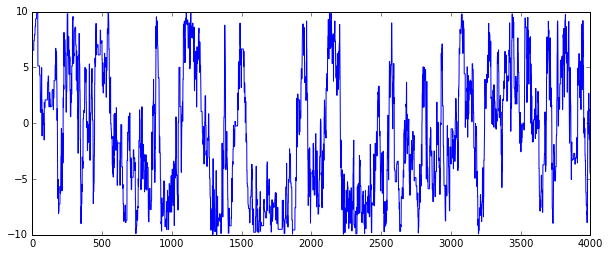

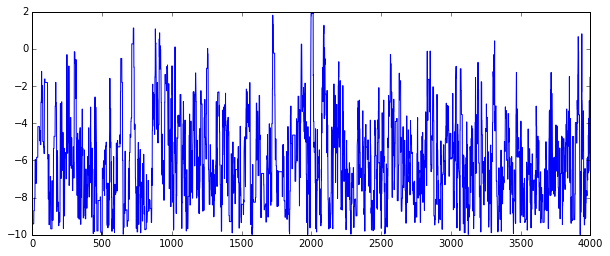

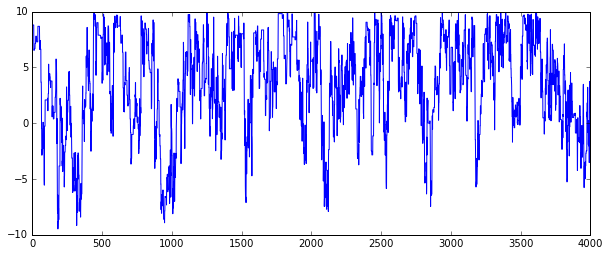

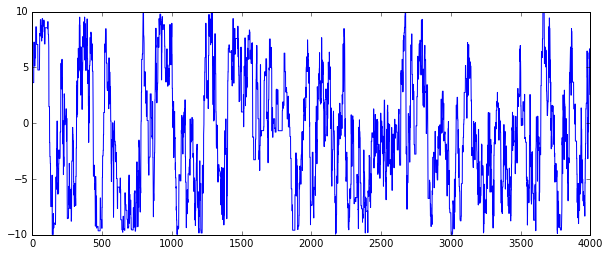

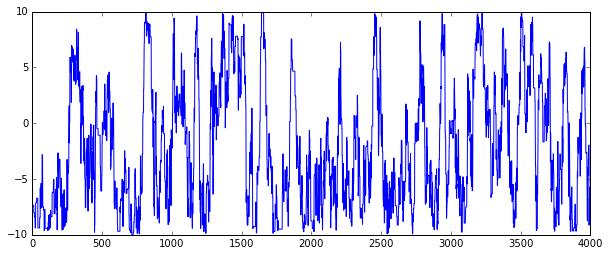

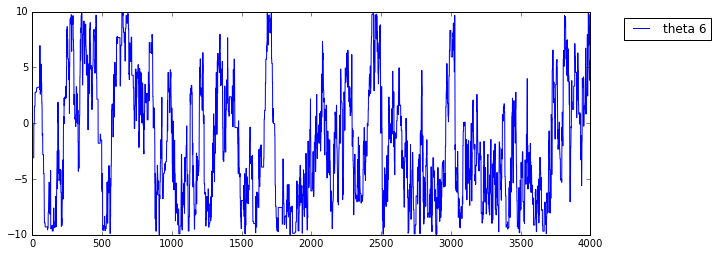

In [269]:
plt.figure(figsize=(8,5))
#print acceptances.sum() * 1./iterations
thin= 1
burn = 1000
thinned_burned = mcmc_thetas[burn:-1:thin, :]
for i in xrange(6):
    plt.figure(figsize=(10,4))
    plt.plot(thinned_burned[:,i], label='theta {}'.format(i+1))
plt.legend(loc=2, bbox_to_anchor=(1.05,1))

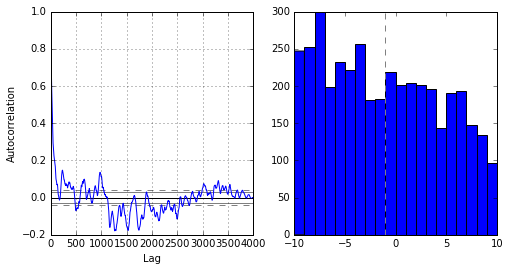

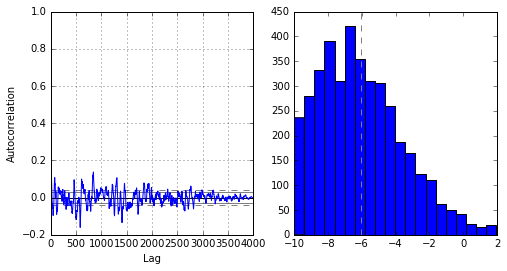

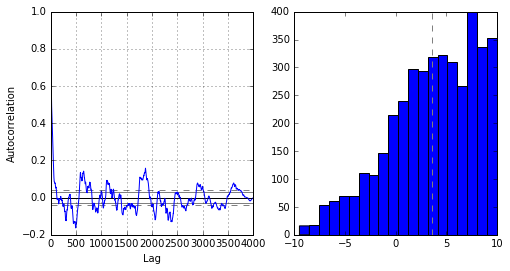

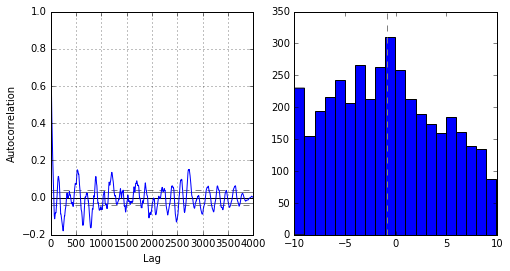

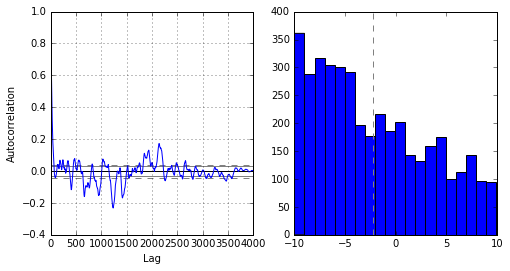

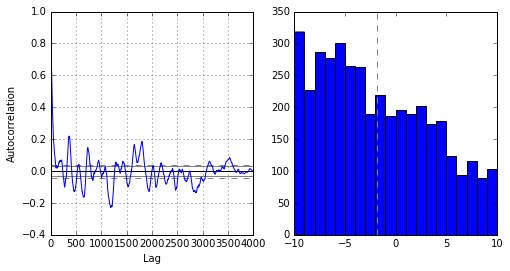

In [276]:
from pandas.tools.plotting import autocorrelation_plot
for i in xrange(thinned_burned.shape[1]):
    t = thinned_burned[:,i]
    plt.figure(figsize=(8,4))
    plt.subplot(121)
    autocorrelation_plot(t, ax=plt.gca())
    plt.subplot(122)
    plt.hist(t, bins=20)
    plt.axvline(t.mean(), linestyle='--', c='gray')

In [271]:
import math
def integers_between(min, max):
    min_int = int(math.floor(min))
    max_int = int(math.ceil(max))
    print min_int, max_int
    return range(min_int, max_int+1)

-10 10
-10 10
-10 2
-10 10
-10 10
-10 10


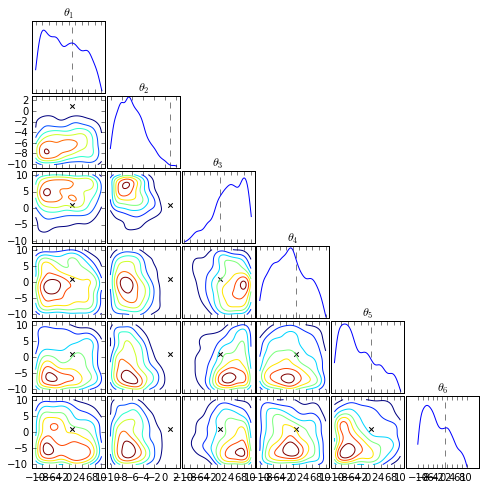

In [272]:
from matplotlib import gridspec
from scipy import stats
plt.figure(figsize=(8,8))
diag = []
n = 6
gs = gridspec.GridSpec(n, n)
gs.update(wspace=0.025, hspace=0.05)

#levels = [5,20,40,60]

levels = None
for i in range(n):
    i_data = thinned_burned[:,i]
    ax = plt.subplot(gs[n*i + i])
    kde = stats.gaussian_kde(i_data)
    eval_points = np.linspace(i_data.min()-0.1, i_data.max()+0.2, 100)
    #plt.axvline(i_data.mean(), linestyle='--', color='gray')
    plt.axvline(1, linestyle='--', color='gray')
    #plt.axvline(-1, linestyle='--', color='gray')
    plt.plot(eval_points, kde(eval_points))
    plt.title('$\\theta_{}$'.format(i+1))
    
    
    ax.get_yaxis().set_ticks([])
    if i < n-1:
        plt.setp(ax.get_xticklabels(), visible=False)
    else:
        plt.xticks(integers_between(i_data.min(), i_data.max())[::2])
    for j in range(0,i):
        j_data = thinned_burned[:,j]
        subax = plt.subplot(gs[n*i+j], sharex=diag[j])
        #H,xedges,yedges = np.histogram2d(j_data, i_data, bins=20)
        kde = stats.gaussian_kde(np.c_[j_data, i_data].T, bw_method=0.35)
        x,y = np.mgrid[j_data.min()-0.1:j_data.max()+0.1:100j, i_data.min()-0.1:i_data.max()+0.2:100j]
        plt.contour(x, y, kde(np.c_[x.ravel(), y.ravel()].T).reshape(x.shape))
        #plt.contour(xedges[:-1], yedges[:-1], H, levels=levels)
        if j > 0:
            subax.get_yaxis().set_ticks([])
        if i < n-1:
            plt.setp(subax.get_xticklabels(), visible=False)
        else:
            plt.xticks(integers_between(j_data.min(), j_data.max())[::2])
        #plt.scatter([1,1,-1,-1],[1,-1,1,-1], marker='x', color='black', linewidth=2, zorder=10)
        plt.scatter(1,1,marker='x', color='black')
    diag.append(ax)
    
plt.gcf().patch.set_alpha(0)
#plt.savefig('PN.pdf', bbox_inches='tight')
plt.savefig('PN_{}.pdf'.format(seed), bbox_inches='tight')
np.save('thetas_{}.npy'.format(seed), thetas)

In [273]:
kde(np.c_[x.ravel(), y.ravel()].T).reshape(x.shape)

array([[ 0.00148144,  0.00161206,  0.00174075, ...,  0.00032793,
         0.00028854,  0.00025197],
       [ 0.00158733,  0.00172777,  0.00186632, ...,  0.00035603,
         0.00031387,  0.00027467],
       [ 0.00168841,  0.00183833,  0.0019864 , ...,  0.00038468,
         0.00033985,  0.00029808],
       ..., 
       [ 0.00025325,  0.000285  ,  0.00031837, ...,  0.00021877,
         0.00020484,  0.0001905 ],
       [ 0.0002308 ,  0.00025968,  0.00029002, ...,  0.00019866,
         0.00018601,  0.00017299],
       [ 0.00020928,  0.00023538,  0.00026278, ...,  0.0001793 ,
         0.00016788,  0.00015614]])

In [274]:
np.c_[x.ravel(), y.ravel()]

array([[-10.068916  , -10.08111892],
       [-10.068916  ,  -9.87632194],
       [-10.068916  ,  -9.67152495],
       ..., 
       [ 10.01152192,   9.78418893],
       [ 10.01152192,   9.98898592],
       [ 10.01152192,  10.19378291]])

In [275]:
print H.shape, xedges.shape

NameError: name 'H' is not defined

In [ ]:
(H > 2).sum()

In [ ]:
(H > 10).sum()

In [ ]:
(H > 80).sum()

In [ ]:
np.save('pn_n=11.npy', thetas)

In [ ]:
np.exp(-last_likelihood - last_prior)

In [ ]:
np.exp(new_likelihood + new_prior)

In [ ]:
posterior = bpdes.collocate(ops, ops_bar, k, None, obs, op_cache, [cur_theta])
mu,cov = posterior(true_x)

In [ ]:
np.dot(mu.ravel()-true_u, np.linalg.inv(cov+likelihood_sigma**2*np.eye(cov.shape[0]))).dot(mu.ravel()-true_u)

In [ ]:
np.exp(0.5*np.log(np.linalg.det(cov+likelihood_sigma**2*np.eye(cov.shape[0]))) + np.dot(mu.ravel()-true_u, np.linalg.inv(cov+likelihood_sigma**2*np.eye(cov.shape[0]))).dot(mu.ravel()-true_u))